Learninig Rate

**A. Target**
1. Pick your last code
2. Make sure  to Add CutOut to your code. It should come from your transformations (albumentations)
3. Use this repo: https://github.com/davidtvs/pytorch-lr-finder
  1. Move LR Finder code to your modules
  2. Implement LR Finder (for SGD, not for ADAM)
  3. Implement ReduceLROnPlatea: https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau

4. Find best LR to train your model
5. Use SDG with Momentum
6. Train for 50 Epochs. 
7. Show Training and Test Accuracy curves
8. Target 88% Accuracy.
9. Run GradCAM on the any 25 misclassified images. Make sure you mention what is the prediction and what was the ground truth label.
10. Submit


**B. Results**
1. Parameters: 11,173,962
2. Best Training Accuracy in 50 epochs: 98.08%
3. Best Test Accuracy in 50 epochs: 91.34 %
4. Total RF reached: 76*76 at the end of Conv block 4

**C. Analysis**

I have implemented Albumentations transforms for normalization ( by finding norm and std values for entire dataset ), Horizontal flip, Vertical flip Rotations and cut our. This acts as a regularizer and now the model is not overfitting to the extent it was earlier

I have implemented the LR finder from given Repo. I have chosen the LR where the loss is minimun which is 0.1 and not suggested by the code. I even tried with the code suggested LR by model was hardly training with that value. 

I have also implemented the grad cam functionality and results are displayed for 30 images


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

import albumentations as A
from collections import Sequence
import numpy as np

from   torch.utils.data import Dataset
import torch.nn.functional as F

In [2]:
!git clone https://github.com/SachinDangayach/TSAI_EVA5.git 

Cloning into 'TSAI_EVA5'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 222 (delta 135), reused 154 (delta 67), pack-reused 0
Receiving objects: 100% (222/222), 3.35 MiB | 14.07 MiB/s, done.
Resolving deltas: 100% (135/135), done.


In [3]:
from TSAI_EVA5.session10.dataset import session10_dataset as dataset
from TSAI_EVA5.session9.models import session8_resnet18_model as models
from TSAI_EVA5.session9.models import session8_train_model as train
from TSAI_EVA5.session9.models import session8_test_model as test
from TSAI_EVA5.session9.utils import session9_utils as utils
from TSAI_EVA5.session10.utils import session10_lr_finder as lr_finder
from TSAI_EVA5.session9.utils import session9_view_gradcam as grad_cam

## Extract, Load and Transform Data

In [4]:
# Calculate Ture Mean and STD
norm_mean,norm_std = dataset.cifar10_mean_std() #  (0.49, 0.48, 0.45), (0.25, 0.24, 0.26)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Extract Datasets
train_set,test_set = dataset.get_datasets()
# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Get train and test transform
train_transform, test_transform = dataset.get_album_transforms(norm_mean,norm_std)

In [7]:
# transform the data
train_set,test_set = dataset.trasnform_datasets(train_set, test_set, train_transform, test_transform)

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
train_loader,test_loader = dataset.get_dataloaders(train_set,test_set)

CUDA Available? True


### Data Exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying 10 images


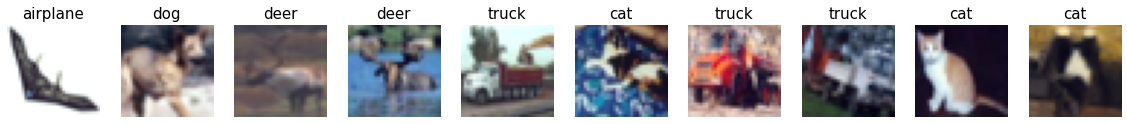

In [8]:
# Explore sample images
utils.show_sample_images(train_loader, classes, .5, .25, num_of_images = 10)

## Import Model and show model summary

In [9]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

# Find Optimal LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.87E+01


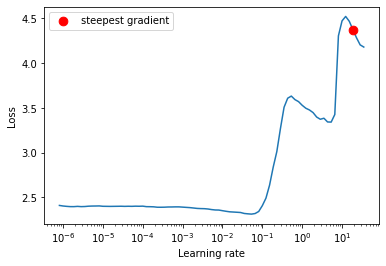

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=0.0005)
lr_finder = lr_finder.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

## Though the suggested LR seems to be but I would prefer the LR where the loss is minimum which seems to be near to .1

## Train and Test Model

In [11]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

optimizer = optim.SGD(model.parameters(), lr=.1, momentum=0.9, weight_decay=0.0005)
# scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, 
                                                 patience=3, threshold=0.01, threshold_mode='abs', 
                                                 cooldown=0, min_lr=0.0001, eps=1e-08, verbose=True)

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train.train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    test.test(model, device, test_loader, test_losses, test_acc)
    scheduler.step(test_acc[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.6494333744049072 Batch_id=390 Train Accuracy=24.88: 100%|██████████| 391/391 [01:00<00:00,  6.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.7231, Test Accuracy: 3509/10000 (35.09%)

EPOCH: 1


Loss=1.3131353855133057 Batch_id=390 Train Accuracy=41.23: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.4541, Test Accuracy: 4676/10000 (46.76%)

EPOCH: 2


Loss=1.23988938331604 Batch_id=390 Train Accuracy=50.37: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3334, Test Accuracy: 5231/10000 (52.31%)

EPOCH: 3


Loss=0.9436915516853333 Batch_id=390 Train Accuracy=57.90: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0701, Test Accuracy: 6110/10000 (61.10%)

EPOCH: 4


Loss=1.022578239440918 Batch_id=390 Train Accuracy=64.03: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0132, Test Accuracy: 6411/10000 (64.11%)

EPOCH: 5


Loss=0.7766300439834595 Batch_id=390 Train Accuracy=66.94: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9847, Test Accuracy: 6499/10000 (64.99%)

EPOCH: 6


Loss=0.7891731262207031 Batch_id=390 Train Accuracy=69.60: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9331, Test Accuracy: 6737/10000 (67.37%)

EPOCH: 7


Loss=0.8195405006408691 Batch_id=390 Train Accuracy=71.84: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8082, Test Accuracy: 7198/10000 (71.98%)

EPOCH: 8


Loss=0.7576736211776733 Batch_id=390 Train Accuracy=73.70: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7791, Test Accuracy: 7308/10000 (73.08%)

EPOCH: 9


Loss=0.7812341451644897 Batch_id=390 Train Accuracy=75.52: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9037, Test Accuracy: 7031/10000 (70.31%)

EPOCH: 10


Loss=0.7362645864486694 Batch_id=390 Train Accuracy=77.09: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7751, Test Accuracy: 7321/10000 (73.21%)

EPOCH: 11


Loss=0.6363875865936279 Batch_id=390 Train Accuracy=77.90: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7490, Test Accuracy: 7463/10000 (74.63%)

EPOCH: 12


Loss=0.6772667169570923 Batch_id=390 Train Accuracy=78.76: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6715, Test Accuracy: 7678/10000 (76.78%)

EPOCH: 13


Loss=0.5962122082710266 Batch_id=390 Train Accuracy=79.57: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6933, Test Accuracy: 7616/10000 (76.16%)

EPOCH: 14


Loss=0.6399978399276733 Batch_id=390 Train Accuracy=80.35: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6561, Test Accuracy: 7684/10000 (76.84%)

EPOCH: 15


Loss=0.5322715044021606 Batch_id=390 Train Accuracy=80.51: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8761, Test Accuracy: 7182/10000 (71.82%)

EPOCH: 16


Loss=0.5300271511077881 Batch_id=390 Train Accuracy=81.03: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8297, Test Accuracy: 7314/10000 (73.14%)

EPOCH: 17


Loss=0.33747220039367676 Batch_id=390 Train Accuracy=81.59: 100%|██████████| 391/391 [01:03<00:00,  6.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6357, Test Accuracy: 7842/10000 (78.42%)

EPOCH: 18


Loss=0.4376693665981293 Batch_id=390 Train Accuracy=81.50: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6059, Test Accuracy: 7937/10000 (79.37%)

EPOCH: 19


Loss=0.51688551902771 Batch_id=390 Train Accuracy=82.42: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7388, Test Accuracy: 7486/10000 (74.86%)

EPOCH: 20


Loss=0.4782702326774597 Batch_id=390 Train Accuracy=82.83: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6136, Test Accuracy: 7945/10000 (79.45%)

EPOCH: 21


Loss=0.38054317235946655 Batch_id=390 Train Accuracy=82.79: 100%|██████████| 391/391 [01:03<00:00,  6.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7264, Test Accuracy: 7609/10000 (76.09%)

EPOCH: 22


Loss=0.4367314875125885 Batch_id=390 Train Accuracy=83.44: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7082, Test Accuracy: 7592/10000 (75.92%)

EPOCH: 23


Loss=0.39655637741088867 Batch_id=390 Train Accuracy=83.48: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5176, Test Accuracy: 8238/10000 (82.38%)

EPOCH: 24


Loss=0.4662376940250397 Batch_id=390 Train Accuracy=83.72: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5908, Test Accuracy: 8040/10000 (80.40%)

EPOCH: 25


Loss=0.6700581312179565 Batch_id=390 Train Accuracy=83.95: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5048, Test Accuracy: 8278/10000 (82.78%)

EPOCH: 26


Loss=0.5924773812294006 Batch_id=390 Train Accuracy=84.11: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6355, Test Accuracy: 7858/10000 (78.58%)

EPOCH: 27


Loss=0.33105701208114624 Batch_id=390 Train Accuracy=83.88: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5578, Test Accuracy: 8102/10000 (81.02%)

EPOCH: 28


Loss=0.4619585871696472 Batch_id=390 Train Accuracy=84.32: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6403, Test Accuracy: 7910/10000 (79.10%)

EPOCH: 29


Loss=0.40212464332580566 Batch_id=390 Train Accuracy=84.25: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6608, Test Accuracy: 7802/10000 (78.02%)

Epoch    30: reducing learning rate of group 0 to 1.0000e-02.
EPOCH: 30


Loss=0.34410738945007324 Batch_id=390 Train Accuracy=90.50: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3015, Test Accuracy: 8934/10000 (89.34%)

EPOCH: 31


Loss=0.22714221477508545 Batch_id=390 Train Accuracy=92.89: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2953, Test Accuracy: 8991/10000 (89.91%)

EPOCH: 32


Loss=0.19305464625358582 Batch_id=390 Train Accuracy=93.68: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2843, Test Accuracy: 9009/10000 (90.09%)

EPOCH: 33


Loss=0.1864299476146698 Batch_id=390 Train Accuracy=94.37: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2841, Test Accuracy: 9011/10000 (90.11%)

EPOCH: 34


Loss=0.12454845011234283 Batch_id=390 Train Accuracy=94.86: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2818, Test Accuracy: 9029/10000 (90.29%)

EPOCH: 35


Loss=0.19815196096897125 Batch_id=390 Train Accuracy=95.22: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2864, Test Accuracy: 9032/10000 (90.32%)

EPOCH: 36


Loss=0.09891638904809952 Batch_id=390 Train Accuracy=95.63: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2755, Test Accuracy: 9073/10000 (90.73%)

EPOCH: 37


Loss=0.1829613745212555 Batch_id=390 Train Accuracy=95.96: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2889, Test Accuracy: 9042/10000 (90.42%)

EPOCH: 38


Loss=0.18044115602970123 Batch_id=390 Train Accuracy=96.24: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2860, Test Accuracy: 9071/10000 (90.71%)

EPOCH: 39


Loss=0.13001370429992676 Batch_id=390 Train Accuracy=96.43: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2886, Test Accuracy: 9045/10000 (90.45%)

EPOCH: 40


Loss=0.050108589231967926 Batch_id=390 Train Accuracy=96.47: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2949, Test Accuracy: 9037/10000 (90.37%)

Epoch    41: reducing learning rate of group 0 to 1.0000e-03.
EPOCH: 41


Loss=0.1276797503232956 Batch_id=390 Train Accuracy=97.25: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2766, Test Accuracy: 9083/10000 (90.83%)

EPOCH: 42


Loss=0.07098732888698578 Batch_id=390 Train Accuracy=97.60: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2721, Test Accuracy: 9104/10000 (91.04%)

EPOCH: 43


Loss=0.046590644866228104 Batch_id=390 Train Accuracy=97.75: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2709, Test Accuracy: 9099/10000 (90.99%)

EPOCH: 44


Loss=0.043064918369054794 Batch_id=390 Train Accuracy=97.81: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2683, Test Accuracy: 9101/10000 (91.01%)

EPOCH: 45


Loss=0.03573388233780861 Batch_id=390 Train Accuracy=97.95: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2699, Test Accuracy: 9114/10000 (91.14%)

EPOCH: 46


Loss=0.05275372415781021 Batch_id=390 Train Accuracy=97.96: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2678, Test Accuracy: 9134/10000 (91.34%)

EPOCH: 47


Loss=0.08055972307920456 Batch_id=390 Train Accuracy=98.00: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2666, Test Accuracy: 9131/10000 (91.31%)

EPOCH: 48


Loss=0.08576333522796631 Batch_id=390 Train Accuracy=97.99: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2692, Test Accuracy: 9129/10000 (91.29%)

EPOCH: 49


Loss=0.022094376385211945 Batch_id=390 Train Accuracy=98.08: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]



Test set: Average loss: 0.2695, Test Accuracy: 9123/10000 (91.23%)



#  Validation accuracies and Loss change curves

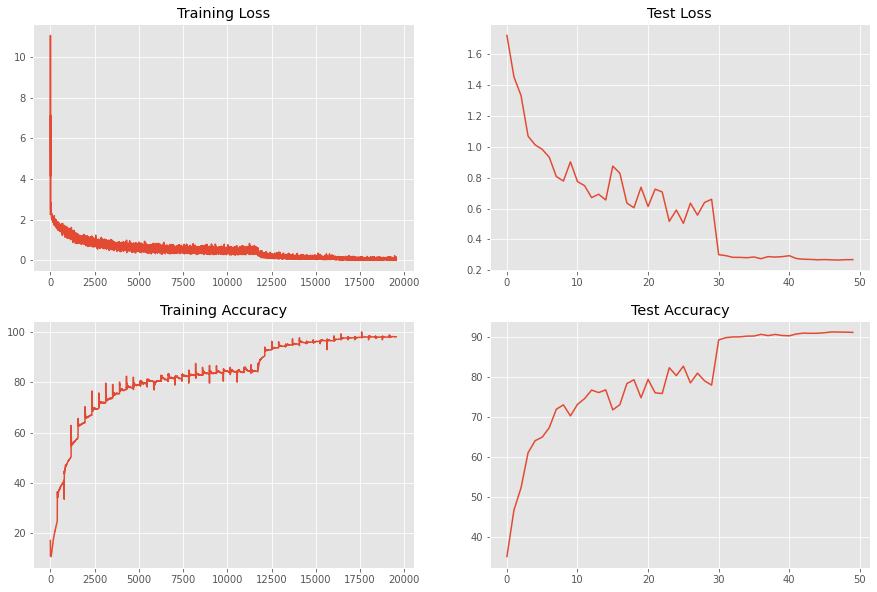

In [12]:
utils.valid_accuracy_loss_plots(train_losses, train_acc, test_losses, test_acc)

## Display misclassified images

In [13]:
images, act_lbl, pred_lbl = utils.get_images_by_results(model,test_loader,number_of_images = 30, mode= 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

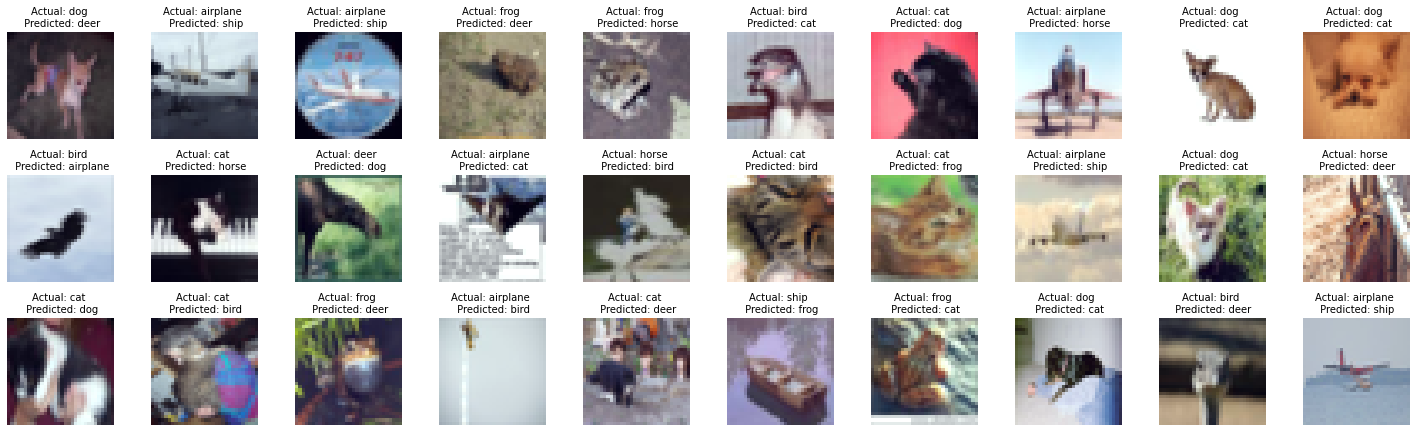

In [14]:
utils.show_images(images, act_lbl, pred_lbl, classes, num_of_images = 30)

# Grad Cam Implementation

In [15]:
model = model.to('cuda')

Mode set to GradCAM.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


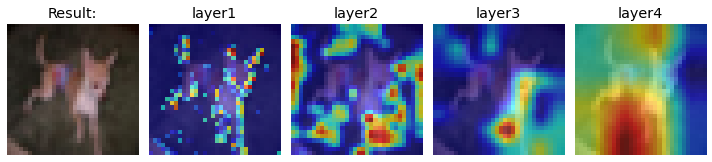

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

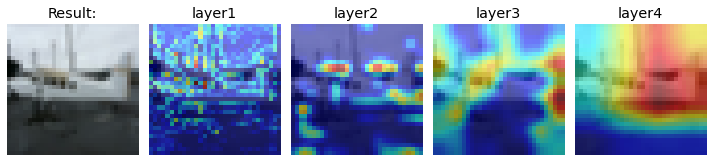

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

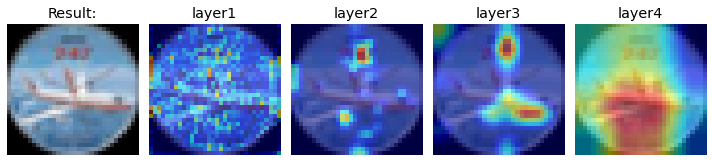

<Figure size 432x288 with 0 Axes>

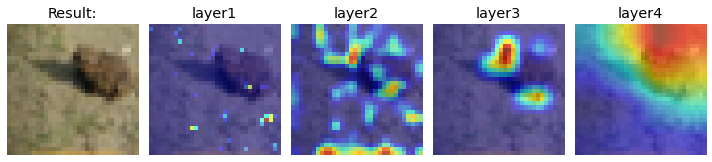

<Figure size 432x288 with 0 Axes>

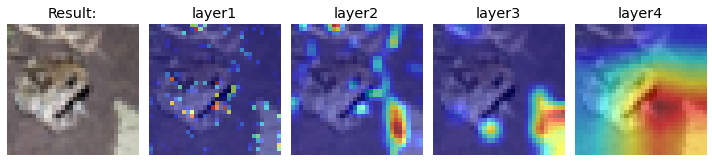

<Figure size 432x288 with 0 Axes>

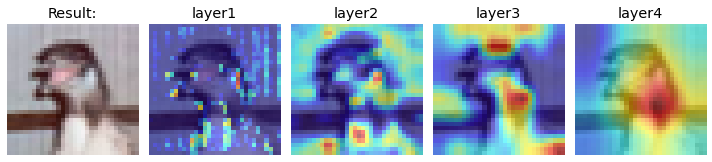

<Figure size 432x288 with 0 Axes>

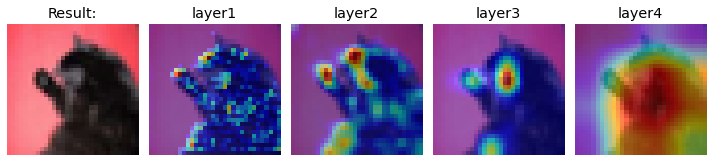

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

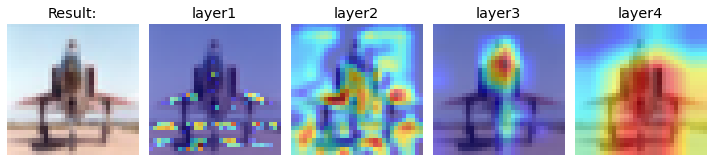

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

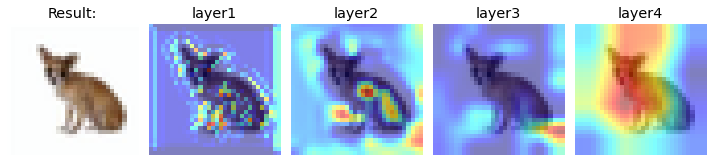

<Figure size 432x288 with 0 Axes>

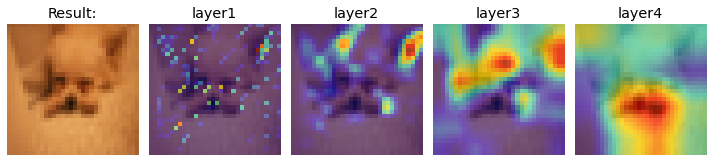

<Figure size 432x288 with 0 Axes>

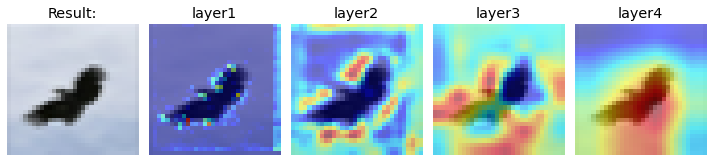

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

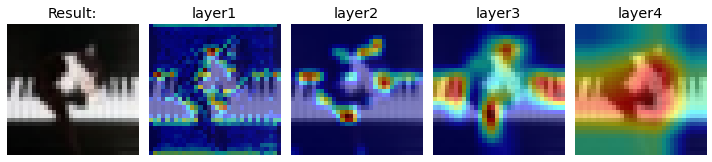

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

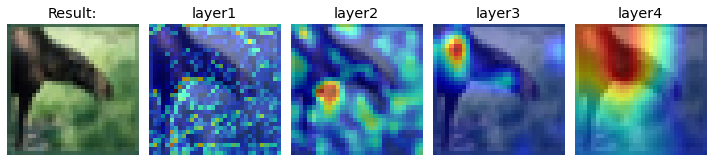

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

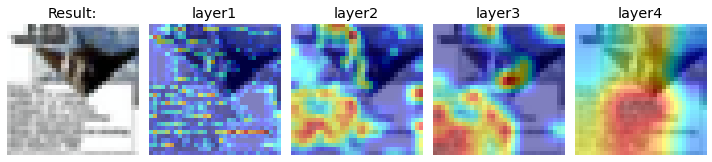

<Figure size 432x288 with 0 Axes>

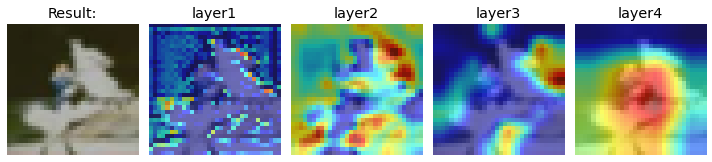

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

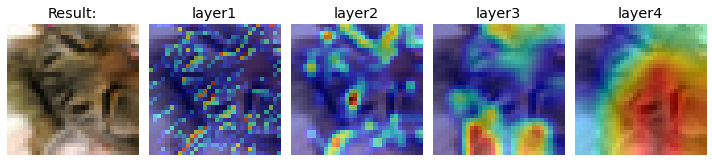

<Figure size 432x288 with 0 Axes>

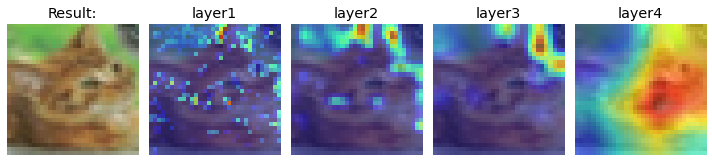

<Figure size 432x288 with 0 Axes>

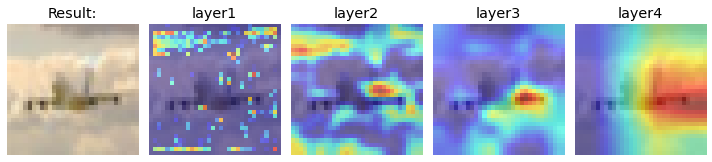

<Figure size 432x288 with 0 Axes>

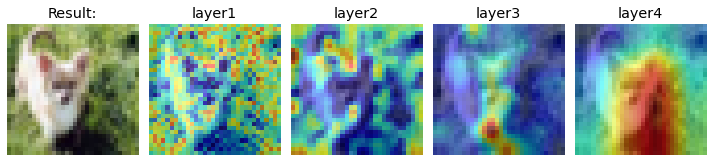

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

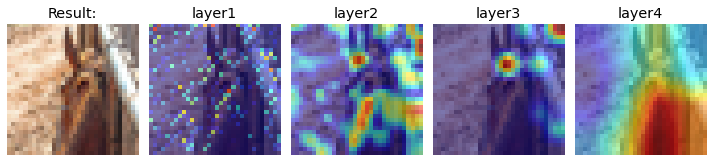

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

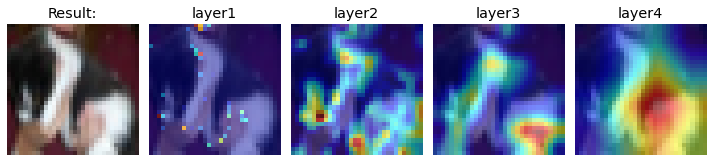

<Figure size 432x288 with 0 Axes>

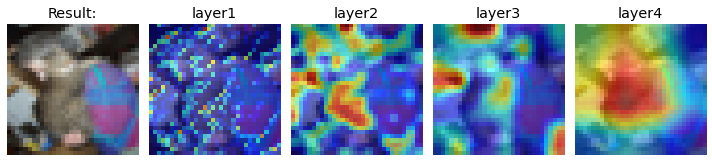

<Figure size 432x288 with 0 Axes>

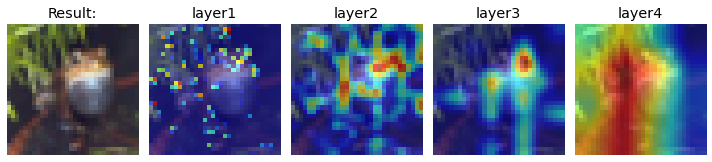

<Figure size 432x288 with 0 Axes>

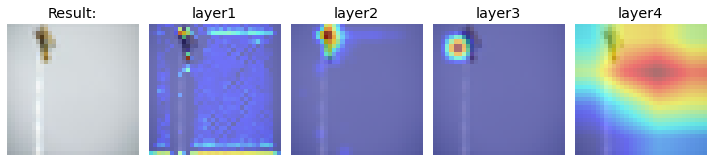

<Figure size 432x288 with 0 Axes>

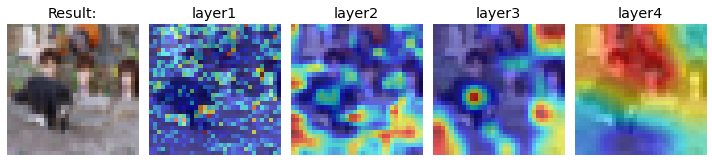

<Figure size 432x288 with 0 Axes>

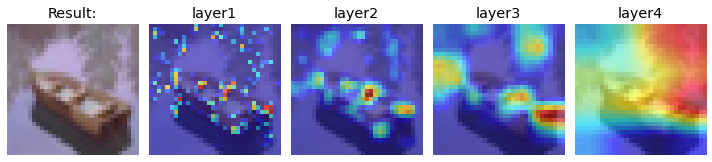

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

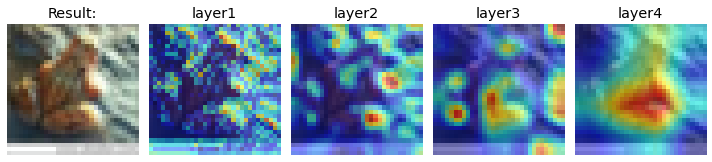

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

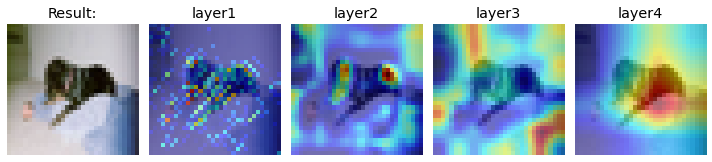

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

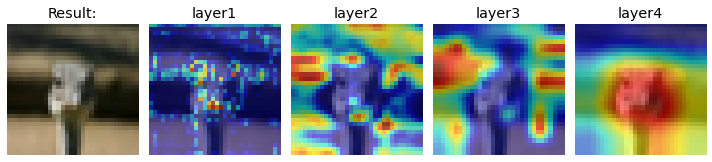

<Figure size 432x288 with 0 Axes>

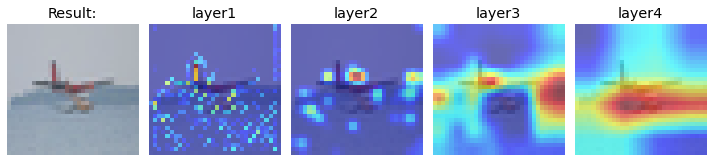

<Figure size 432x288 with 0 Axes>

In [16]:
grad_cam = grad_cam.GradCAMView(
    model, ['layer1', 'layer2', 'layer3', 'layer4'],
    device, norm_mean,norm_std 
)

# Show grad cam for above mentioned miss classified images 
grad_cam(images, 'grad_cam')